In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt

In [2]:
df = pd.read_csv("/content/dataset.csv")
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)
df['VehicleType'] = df['VehicleType'].map({'car': 1, 'bike': 0.5, 'truck': 1.5})
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].map({'low': 1, 'medium': 2, 'high': 3})
df.fillna(0, inplace=True)

In [3]:
df['base_price'] = 10.0
df['price_model_1'] = df['base_price']
df['price_model_2'] = df['base_price']
df['price_model_3'] = df['base_price']

In [4]:
alpha1 = 1.0
alpha2, beta, gamma, delta, epsilon, lambd = 0.5, 0.3, 0.2, 1.0, 0.3, 0.5

In [5]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    return 6371 * c  # km

In [6]:
lots = df.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first().reset_index()
dist_matrix = {}
for i, row1 in lots.iterrows():
    for j, row2 in lots.iterrows():
        if row1['SystemCodeNumber'] != row2['SystemCodeNumber']:
            key = (row1['SystemCodeNumber'], row2['SystemCodeNumber'])
            dist_matrix[key] = haversine(row1['Latitude'], row1['Longitude'], row2['Latitude'], row2['Longitude'])

# Pricing logic for each parking lot
for lot_id, lot_df in df.groupby('SystemCodeNumber'):
    lot_df = lot_df.sort_values('timestamp')
    prices_m1, prices_m2, prices_m3 = [], [], []
    prev_price_m1 = prev_price_m3 = 10.0

    for timestamp, row in lot_df.iterrows():
        occ_ratio = row['Occupancy'] / row['Capacity'] if row['Capacity'] > 0 else 0

        # Model 1: Linear
        price_m1 = prev_price_m1 + alpha1 * occ_ratio
        prices_m1.append(price_m1)
        prev_price_m1 = price_m1

        # Model 2: Demand-based
        demand = (
            alpha2 * occ_ratio +
            beta * row['QueueLength'] -
            gamma * row['TrafficConditionNearby'] +
            delta * row['IsSpecialDay'] +
            epsilon * row['VehicleType']
        )
        norm_demand = (demand - df['Occupancy'].min()) / (df['Occupancy'].max() - df['Occupancy'].min() + 1e-6)
        price_m2 = row['base_price'] * (1 + lambd * norm_demand)
        price_m2 = np.clip(price_m2, 5, 20)
        prices_m2.append(price_m2)

        # Model 3: Competition-aware
        nearby_prices = []
        for other_lot in lots['SystemCodeNumber']:
            if other_lot == lot_id:
                continue
            if dist_matrix.get((lot_id, other_lot), float('inf')) < 1.0:  # within 1 km
                other_prices = df[(df['SystemCodeNumber'] == other_lot) & (df['timestamp'] == row['timestamp'])]['price_model_2']
                if not other_prices.empty:
                    nearby_prices.append(other_prices.values[0])
        avg_nearby_price = np.mean(nearby_prices) if nearby_prices else price_m2

        if occ_ratio > 0.9 and price_m2 > avg_nearby_price:
            price_m3 = avg_nearby_price  # reroute suggestion implied
        elif price_m2 < avg_nearby_price:
            price_m3 = price_m2 + 0.5 * (avg_nearby_price - price_m2)
        else:
            price_m3 = price_m2

        price_m3 = np.clip(price_m3, 5, 20)
        prices_m3.append(price_m3)
        prev_price_m3 = price_m3

In [7]:
    df.loc[lot_df.index, 'price_model_1'] = prices_m1
    df.loc[lot_df.index, 'price_model_2'] = prices_m2
    df.loc[lot_df.index, 'price_model_3'] = prices_m3

In [8]:
example_lot = df[df['SystemCodeNumber'] == df['SystemCodeNumber'].iloc[0]]
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

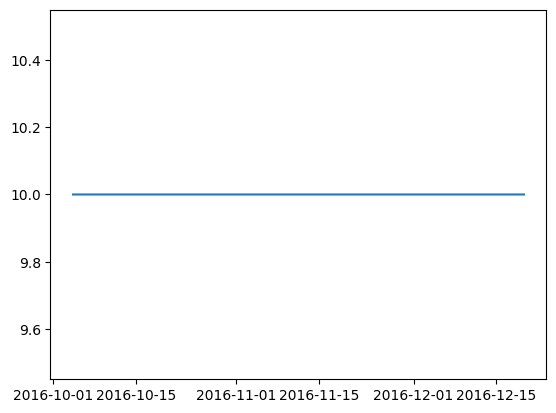

In [9]:
plt.plot(example_lot['timestamp'], example_lot['price_model_1'], label='Model 1: Linear')

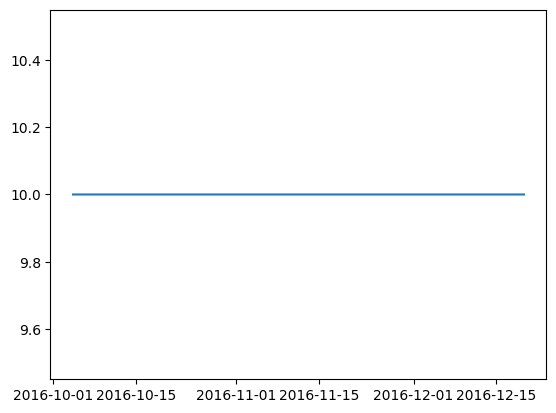

In [10]:
plt.plot(example_lot['timestamp'], example_lot['price_model_2'], label='Model 2: Demand-Based')

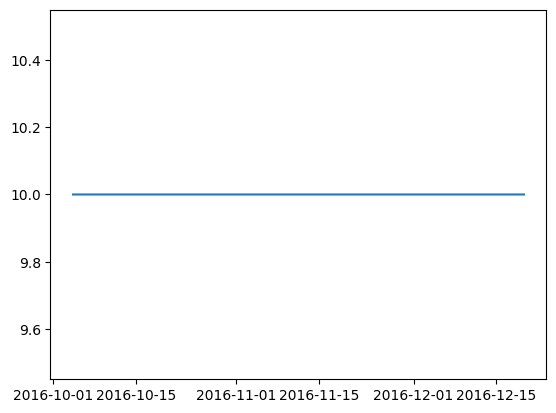

In [11]:
plt.plot(example_lot['timestamp'], example_lot['price_model_3'], label='Model 3: Competition-Aware')

Text(0.5, 0, 'Time')

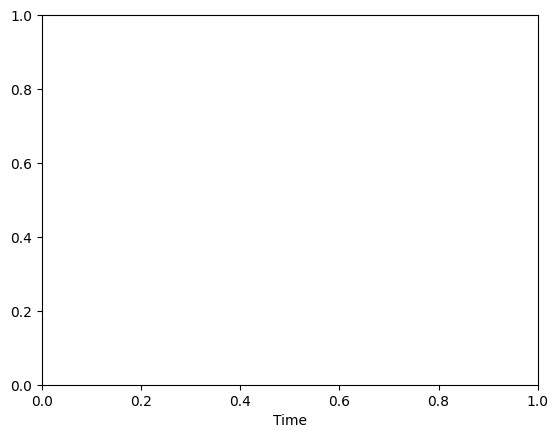

In [12]:
plt.xlabel("Time")

Text(0, 0.5, 'Price ($)')

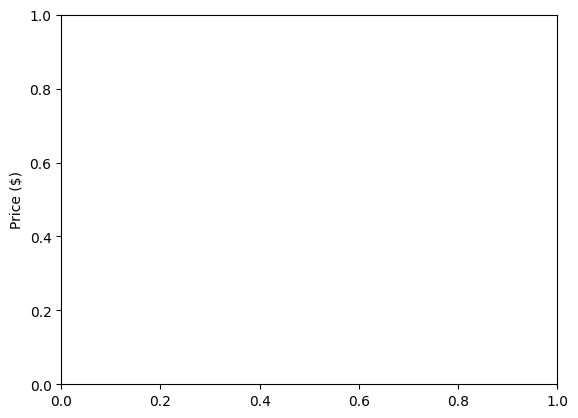

In [13]:
plt.ylabel("Price ($)")

Text(0.5, 1.0, 'Dynamic Pricing for Lot: BHMBCCMKT01')

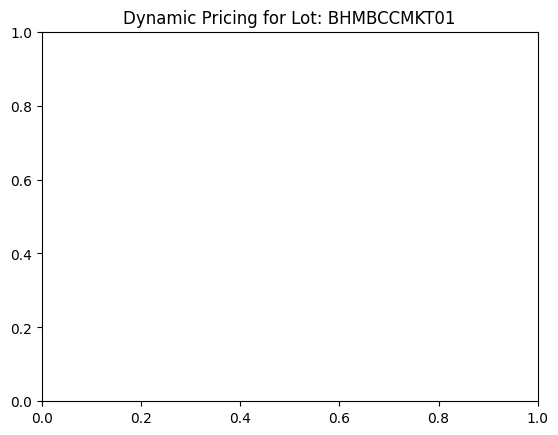

In [14]:
plt.title(f"Dynamic Pricing for Lot: {example_lot['SystemCodeNumber'].iloc[0]}")

/tmp/ipython-input-15-4061938096.py:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


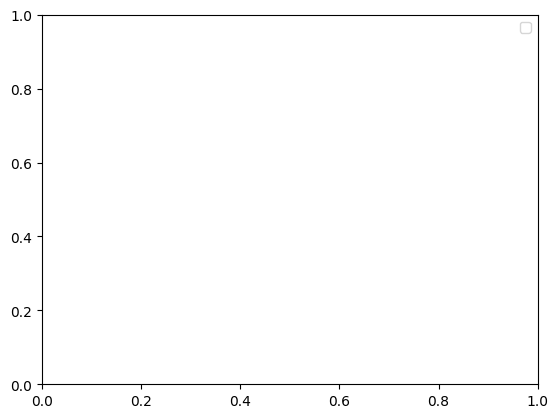

In [15]:
plt.legend()

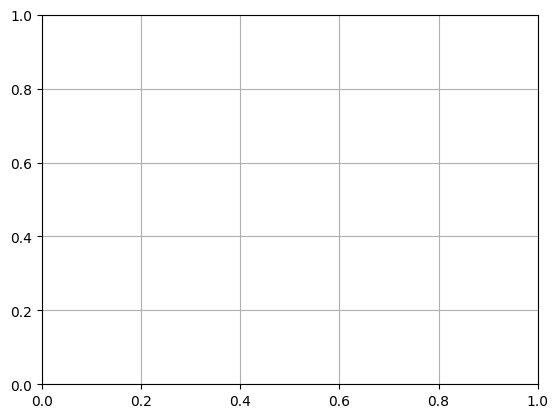

In [16]:
plt.grid(True)

In [17]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [18]:
plt.show()